In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install efficientnet==1.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.8 MB/s eta 0:00:00


In [3]:
!pip install tensorflow==2.4.3


ERROR: Could not find a version that satisfies the requirement tensorflow==2.4.3 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0)
ERROR: No matching distribution found for tensorflow==2.4.3


In [4]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import binary_crossentropy, categorical_crossentropy
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras import backend as K
from tqdm import tqdm
import efficientnet.tfkeras as efn
import tensorflow as tf
import pandas as pd
import numpy as np
import logging
import cv2
import os

In [5]:
tf.__version__

'2.15.0'

In [6]:
!nvidia-smi

Thu Jul 18 21:06:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
#load the datasets
#train and validation data structure--|

train = "/content/drive/MyDrive/Bhuwan_project/fake_logo_logo/data/train/"
val = "/content/drive/MyDrive/Bhuwan_project/fake_logo_logo/data/val/"

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True)

In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 2032 images belonging to 8 classes.


In [12]:
print("train_generator: ",train_generator)

train_generator:  <keras.src.preprocessing.image.DirectoryIterator object at 0x7d68d07b44f0>


In [13]:
validation_generator = test_datagen.flow_from_directory(
    val,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 201 images belonging to 8 classes.


In [14]:
img_size = (224,224)
if K.image_data_format() == "channels_first":
    input_shape = (3, img_size[0], img_size[1])
else:
    input_shape = (img_size[0], img_size[1], 3)
base = efn.EfficientNetB2(include_top=False, weights="imagenet", input_shape=input_shape)

31936256/31936256 [==============================] - 0s 0us/step


In [15]:
x1 = GlobalAveragePooling2D(name="gap")(base.output)
x2 = GlobalMaxPooling2D(name="gmp")(base.output)
x = Concatenate(name="concat")([x1, x2])

In [16]:
x = Dense(8, kernel_initializer="he_normal", name="classifier")(x)
x = Activation("softmax", name="softmax")(x)

In [17]:
model = tf.keras.models.Model(inputs=base.input, outputs=x)

In [18]:
loss = tf.keras.losses.CategoricalCrossentropy()
opt = tf.optimizers.Adam(lr=1e-3)
epochs = 40
bs = 16

In [19]:
model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])


In [20]:
model.fit(train_generator, validation_data=validation_generator, epochs=epochs, batch_size=bs,
                        steps_per_epoch=len(train_generator), validation_steps=len(validation_generator))

Epoch 1/40
64/64 [==============================] - 846s 12s/step - loss: 0.4804 - accuracy: 0.8868 - val_loss: 0.2223 - val_accuracy: 0.9154
Epoch 2/40
64/64 [==============================] - 47s 736ms/step - loss: 0.0818 - accuracy: 0.9788 - val_loss: 0.2837 - val_accuracy: 0.9353
Epoch 3/40
64/64 [==============================] - 48s 746ms/step - loss: 0.0644 - accuracy: 0.9838 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 4/40
64/64 [==============================] - 46s 712ms/step - loss: 0.0660 - accuracy: 0.9813 - val_loss: 0.0428 - val_accuracy: 0.9900
Epoch 5/40
64/64 [==============================] - 47s 734ms/step - loss: 0.0331 - accuracy: 0.9877 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 6/40
64/64 [==============================] - 46s 720ms/step - loss: 0.0324 - accuracy: 0.9872 - val_loss: 0.0641 - val_accuracy: 0.9851
Epoch 7/40
64/64 [==============================] - 47s 734ms/step - loss: 0.0995 - accuracy: 0.9779 - val_loss: 0.4688 - val_accuracy: 0.9453


In [21]:
# model.history.history

In [22]:
# model.history.epoch

In [23]:
model.save('/content/drive/MyDrive/Bhuwan_project/fake_logo_logo/Fake_logo_classification.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
hist_epoch = model.history.epoch
hist_acc_loss = model.history.history
import pickle as pkl
with open('/content/drive/MyDrive/Bhuwan_project/emotional_facial/hist_epocheb2','wb') as f:
  pkl.dump(hist_epoch,f)

with open('/content/drive/MyDrive/Bhuwan_project/emotional_facial/hist_acc_losseb2','wb') as f:
  pkl.dump(hist_acc_loss,f)

In [ ]:
import pickle as pkl
with open('/content/drive/MyDrive/Bhuwan_project/emotional_facial/hist_epocheb2','rb') as file:
  hist_epoch = pkl.load(file)

with open('/content/drive/MyDrive/Bhuwan_project/emotional_facial/hist_acc_losseb2','rb') as file:
  hist_acc_loss = pkl.load(file)

print(hist_epoch)
print(hist_acc_loss)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
{'loss': [1.820937991142273, 0.7039238810539246, 0.4727875888347626, 0.3735034763813019, 0.2601020932197571, 0.23023559153079987, 0.21872588992118835, 0.14566700160503387, 0.12972360849380493, 0.16618597507476807, 0.17779958248138428, 0.15127092599868774, 0.1524312049150467, 0.12853646278381348, 0.13404053449630737, 0.09422790259122849, 0.12171163409948349, 0.08372964709997177, 0.07620804756879807, 0.05258667469024658, 0.055805642157793045, 0.06256307661533356, 0.15742610394954681, 0.12932948768138885, 0.16681508719921112, 0.15197332203388214, 0.1069631427526474, 0.06752761453390121, 0.05026403069496155, 0.05315783619880676, 0.07254461944103241, 0.12573763728141785, 0.08318625390529633, 0.08050043135881424, 0.058254167437553406, 0.05718313157558441, 0.08335283398628235, 0.11659113317728043, 0.11931680142879486, 0.10806629061698914], 'acc

In [ ]:
# l = len(hist_epoch)
# l

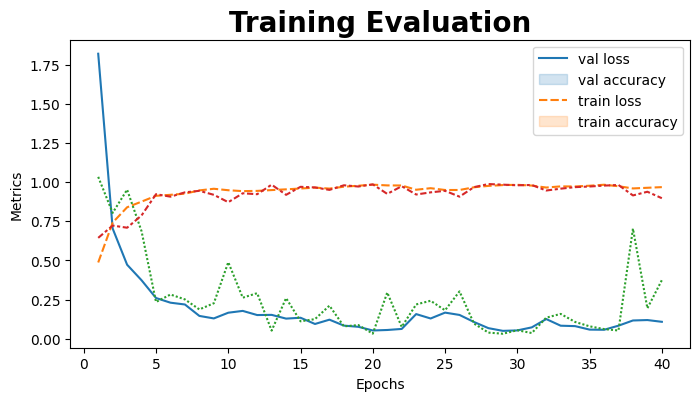

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(figsize = (8,4))
sns.lineplot(data = pd.DataFrame(hist_acc_loss, index = range(1, 1 + len(hist_epoch))))
plt.title("Training Evaluation", fontweight = "bold", fontsize = 20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend(labels = ['val loss','val accuracy','train loss','train accuracy'])
plt.show()

In [6]:
#load the model
import glob
import cv2

model = tf.keras.models.load_model("/content/drive/MyDrive/Bhuwan_project/fake_logo_logo/Fake_logo_classification.h5")
class_name = ['Adidas','Puma','Samsung','Twitter','fake_adidas','fake_puma','fake_samsung','fake_twitter']


dest_path = "/content/drive/MyDrive/Bhuwan_project/fake_logo_logo/data/result/"
for i in glob.glob("/content/drive/MyDrive/Bhuwan_project/fake_logo_logo/data/test/*"):
  file_name = i.split('/')[-1]
  img1 = cv2.imread(i)
  img = cv2.resize(img1, (224,224))

  # convert the image to a tensor for inference
  img = np.expand_dims(img, 0).astype(np.float32) / 255.0
  preds = np.squeeze(model.predict(img)[0])
  index = np.argmax(preds)
  cls_name =class_name[index]
  print(file_name," : ",cls_name)
  cv2.putText(img1, cls_name, (50,50), cv2.FONT_HERSHEY_SIMPLEX,
                   1, (255, 0, 0), 3, cv2.LINE_AA)
  cv2.imwrite(dest_path+file_name,img1)


1/1 [==============================] - 6s 6s/step
org_Adidas (2).jpg  :  Adidas
1/1 [==============================] - 0s 28ms/step
org_Adidas (1).jpg  :  Adidas
1/1 [==============================] - 0s 27ms/step
org_samsung (1).jpg  :  Samsung
1/1 [==============================] - 0s 28ms/step
org_puma (2).jpg  :  Puma
1/1 [==============================] - 0s 38ms/step
org_samsung (2).jpg  :  Samsung
1/1 [==============================] - 0s 28ms/step
org_puma (1).jpg  :  Puma
1/1 [==============================] - 0s 27ms/step
org_twitter (1).jpg  :  Twitter
1/1 [==============================] - 0s 41ms/step
org_twitter (2).jpg  :  Twitter
1/1 [==============================] - 0s 41ms/step
fake_adidas (2).png  :  fake_adidas
1/1 [==============================] - 0s 53ms/step
fake_adidas (1).png  :  fake_adidas
1/1 [==============================] - 0s 27ms/step
fake_twitter (1).png  :  Adidas
1/1 [==============================] - 0s 27ms/step
fake_twitter (2).png  :  fake_twit

In [ ]:
/content/drive/MyDrive/Bhuwan_project/fake_logo_logo/Fake_logo_classification.h5